In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Dataset Exploration

## Load the dataset

We load CIFAR-10 using `tensorflow_datasets` with the dataset information (`with_info=True`) to access metadata such as the number of classes, splits, and features.

In [5]:
(cifar_train, cifar_test), cifar_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

print("Dataset loaded.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.BYIGWB_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.BYIGWB_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Dataset loaded.


## Dataset size and class distribution


In [6]:
stats = {
    'num_train': cifar_info.splits['train'].num_examples,
    'num_test': cifar_info.splits['test'].num_examples,
    'num_classes': cifar_info.features['label'].num_classes,
    'class_names': cifar_info.features['label'].names
}
stats['num_total'] = stats['num_train'] + stats['num_test']
print("=" * 110)
print("Dataset Size Review")
print("=" * 110)
print(f"Training samples : {stats['num_train']:,}")
print(f"Test samples : {stats['num_test']:,}")
print(f"Total samples : {stats['num_total']:,}")
print(f"Number of classes : {stats['num_classes']}")
print(f"Classes : {stats['class_names']}")
print("=" * 110)

Dataset Size Review
Training samples : 50,000
Test samples : 10,000
Total samples : 60,000
Number of classes : 10
Classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# Dataset distribution
train_labels = []
test_labels = []

for _, label in cifar_train:
    train_labels.append(label.numpy())

train_label_counts = Counter(train_labels)

for _, label in cifar_test:
    test_labels.append(label.numpy())

test_label_counts = Counter(test_labels)

num_classes = stats['num_classes']
class_names = stats['class_names']

print("\n" + "=" * 60)
print("Classes Distribution")
print("=" * 60)
print(f"  {'Class':<15} {'ID':<5} {'Train':<10} {'Test':<10} {'Total':<10}")
print("-" * 60)
for i, name in enumerate(class_names):
    training_count = train_label_counts.get(i, 0)
    test_count = test_label_counts.get(i, 0)
    print(f"{name:<15} {i:<5} {training_count:<10} {test_count:<10} {training_count+test_count:<10}")
print("-" * 60)
print(f"{'TOTAL':<15} {'':<5} {sum(train_label_counts.values()):<10} "
      f"{sum(test_label_counts.values()):<10} "
      f"{sum(train_label_counts.values()) + sum(test_label_counts.values()):<10}")
print("=" * 60)


Classes Distribution
  Class           ID    Train      Test       Total     
------------------------------------------------------------
airplane        0     5000       1000       6000      
automobile      1     5000       1000       6000      
bird            2     5000       1000       6000      
cat             3     5000       1000       6000      
deer            4     5000       1000       6000      
dog             5     5000       1000       6000      
frog            6     5000       1000       6000      
horse           7     5000       1000       6000      
ship            8     5000       1000       6000      
truck           9     5000       1000       6000      
------------------------------------------------------------
TOTAL                 50000      10000      60000     


We can see in the table that training set and test set have the exact number of samples per class (5000 and 1000)

## Image dimensions and channels

We verify the spatial dimensions (height × width), the number of color channels, and the data type of the pixels.

In [8]:
# Obtain a sample
sample_image, sample_label = next(iter(cifar_train))

print("=" * 55)
print("Image properties")
print("=" * 55)
print(f"Image Shape : {sample_image.shape}")
print(f"Height : {sample_image.shape[0]} px")
print(f"Width : {sample_image.shape[1]} px")
print(f"Channels : {sample_image.shape[2]} (RGB)")
print("=" * 55)

# Verify that ALL images have the same dimensions
print("\nChecking dimensional consistency across the entire dataset...")
shapes_set = set()
for img, _ in cifar_train.take(500):
    shapes_set.add(tuple(img.shape.as_list()))
for img, _ in cifar_test.take(500):
    shapes_set.add(tuple(img.shape.as_list()))

if len(shapes_set) == 1:
    print(f"\n All verified images have the same dimensions: {shapes_set.pop()}")
else:
    print(f"\n Different dimensions were found: {shapes_set}")

Image properties
Image Shape : (32, 32, 3)
Height : 32 px
Width : 32 px
Channels : 3 (RGB)

Checking dimensional consistency across the entire dataset...

 All verified images have the same dimensions: (32, 32, 3)


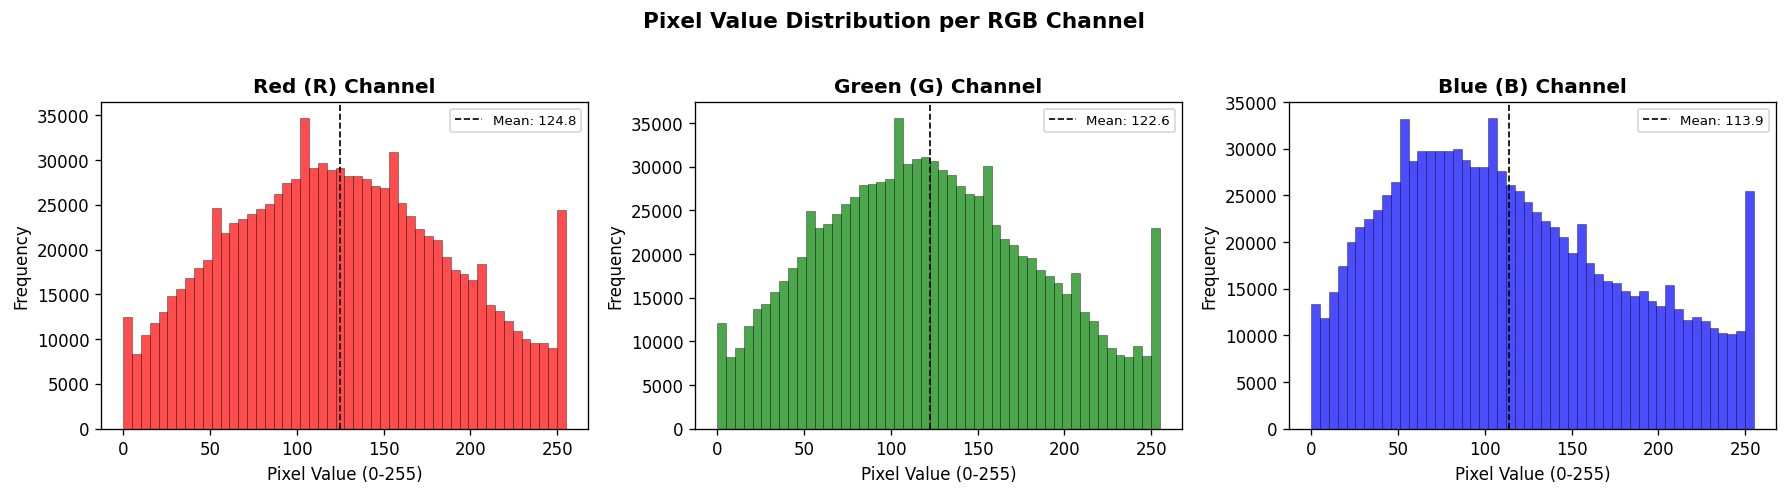

In [9]:
# Basic pixel value statistics (on a subset)
pixel_values = []
for img, _ in cifar_train.take(1000):
    pixel_values.append(img.numpy())

pixel_array = np.array(pixel_values)

# Histogram of pixel value distribution per channel
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
channel_names = ['Red (R)', 'Green (G)', 'Blue (B)']
channel_colors = ['red', 'green', 'blue']

for i, (ax, name, color) in enumerate(zip(axes, channel_names, channel_colors)):
    ax.hist(pixel_array[:,:,:,i].flatten(), bins=50, color=color, alpha=0.7,
            edgecolor='black', linewidth=0.3)
    ax.set_title(f'{name} Channel', fontweight='bold')
    ax.set_xlabel('Pixel Value (0-255)')
    ax.set_ylabel('Frequency')
    ax.axvline(pixel_array[:,:,:,i].mean(), color='black', linestyle='--',
               linewidth=1, label=f'Mean: {pixel_array[:,:,:,i].mean():.1f}')
    ax.legend(fontsize=8)

plt.suptitle('Pixel Value Distribution per RGB Channel', fontweight='bold',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('channel_histogram.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualization of Samples by Class

We show representative examples of each of the 10 classes to provide a visual overview of the dataset's contents.



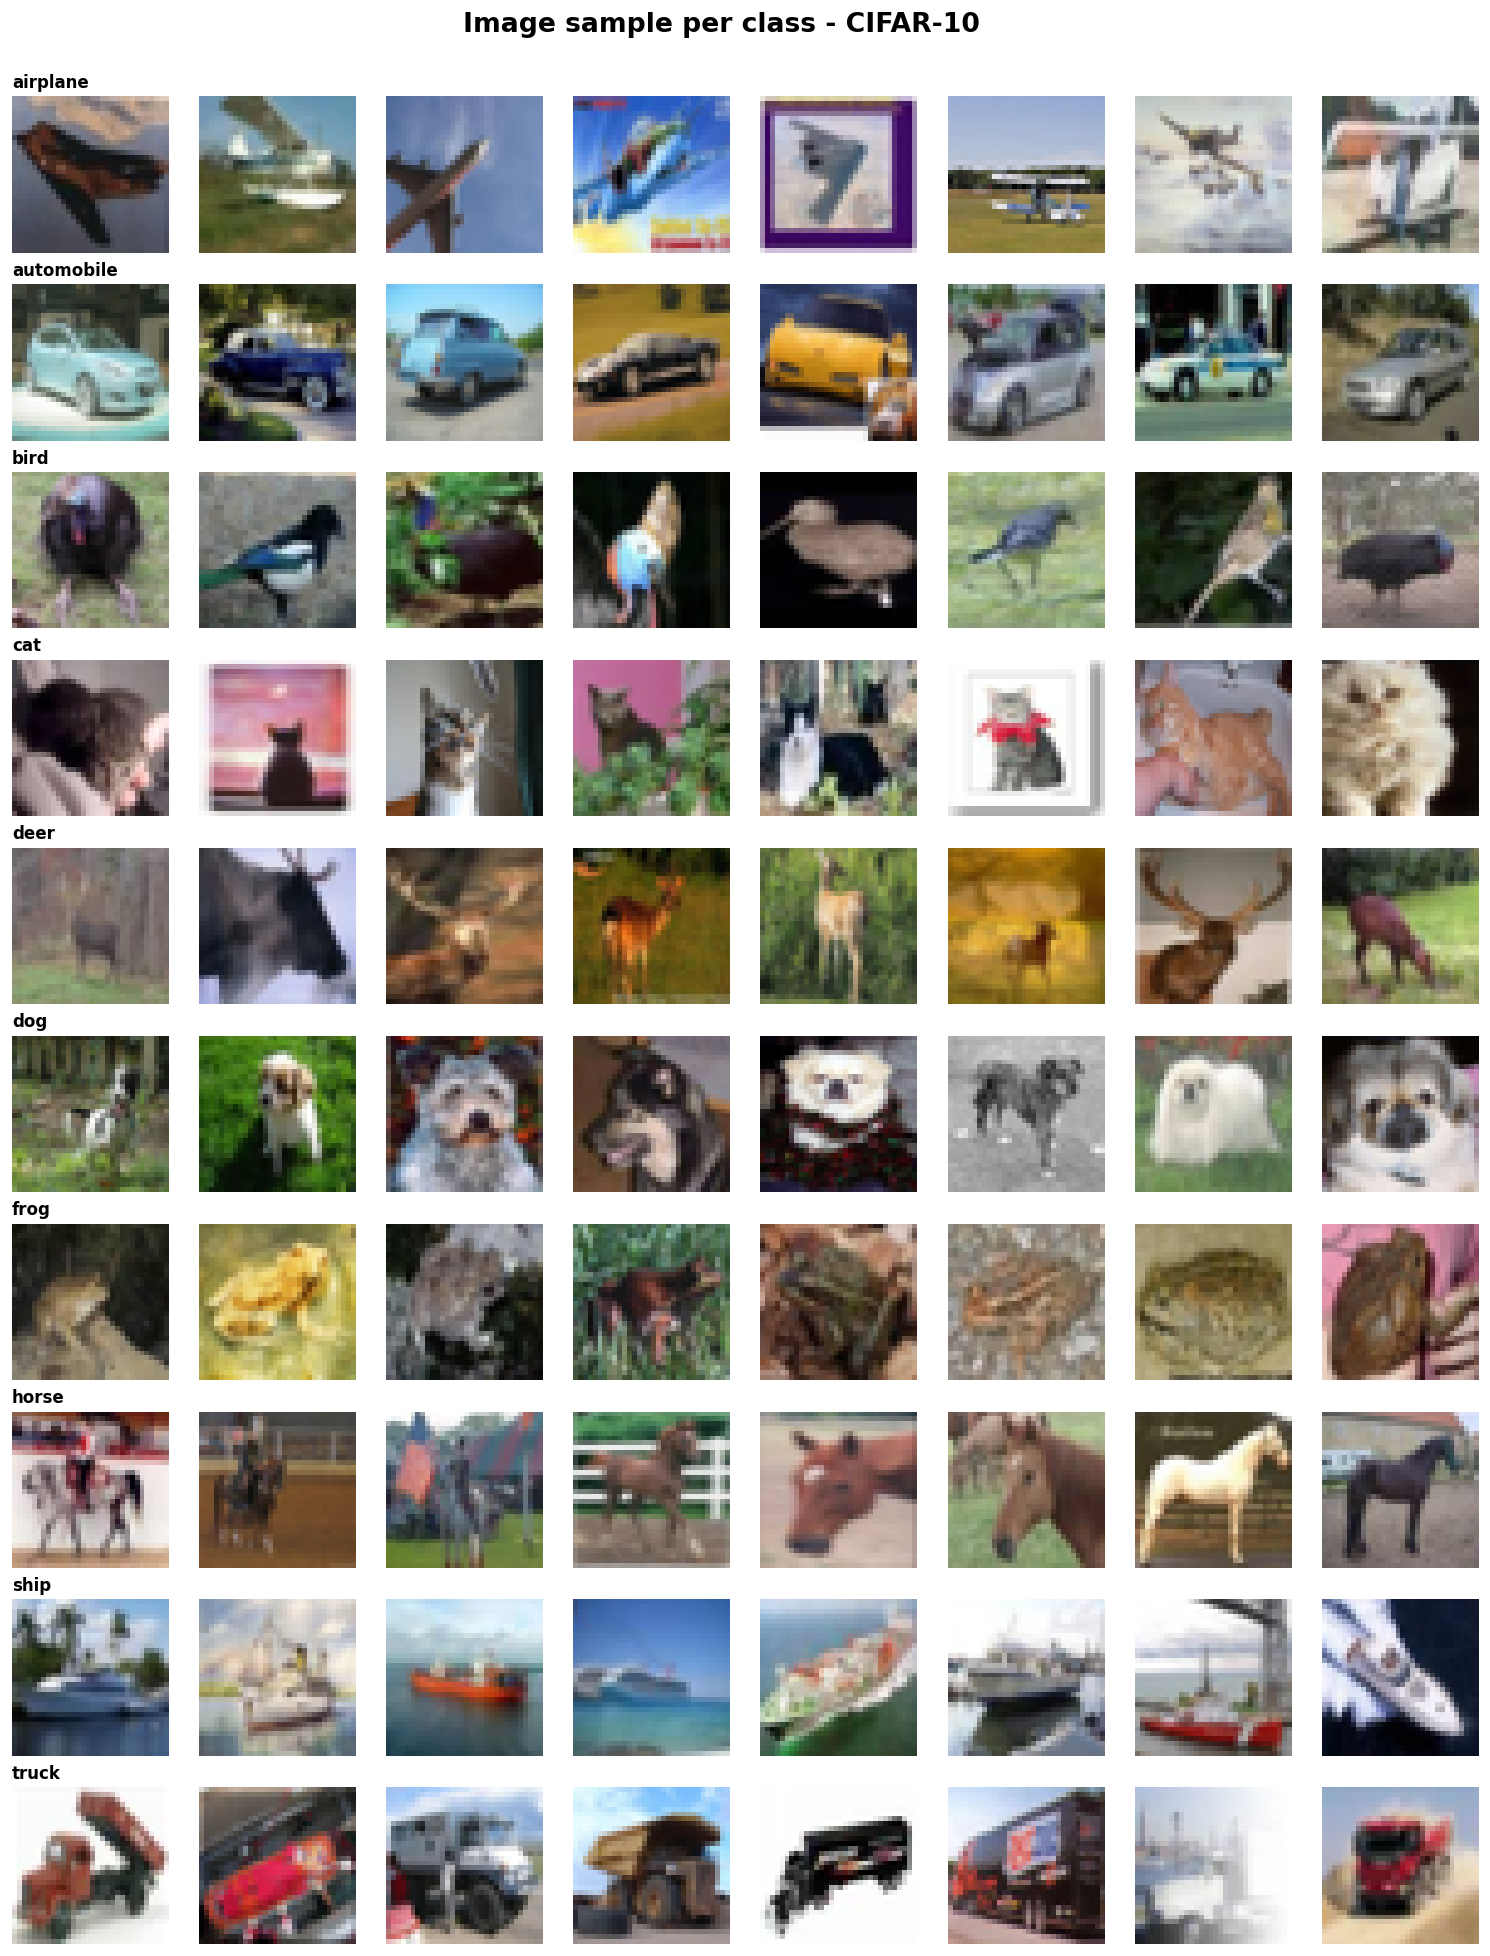


-> We see 8 random samples for each class.


In [10]:
# Collect samples by class
samples_per_class = {i: [] for i in range(num_classes)}
num_samples = 8  # sample per class

for img, label in cifar_train:
    lbl = label.numpy()
    if len(samples_per_class[lbl]) < num_samples:
        samples_per_class[lbl].append(img.numpy())
    # Check if we already have enough samples of all classes
    if all(len(v) >= num_samples for v in samples_per_class.values()):
        break

# Display one row per class, 8 columns of samples
fig, axes = plt.subplots(num_classes, num_samples, figsize=(16, 20))
fig.suptitle('Image sample per class - CIFAR-10', fontsize=16, fontweight='bold', y=0.915)
for row_idx in range(num_classes):
    for col_idx in range(num_samples):
        ax = axes[row_idx, col_idx]
        ax.imshow(samples_per_class[row_idx][col_idx])
        ax.axis('off')
        if col_idx == 0:
            ax.set_title(f'{class_names[row_idx]}', fontsize=10, fontweight='bold',
                        loc='left', pad=5)

plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.savefig('sample_per_class.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n-> We see {num_samples} random samples for each class.")

## Preprocessing: normalization and resizing

We applied two fundamental transformations to prepare the data for use in deep learning models:

1. **Normalization**: Scaled the pixel values from `[0, 255]` to `[0.0, 1.0]` (float32).

2. **Resizing**: Resized the images from `32x32` to `64x64` to demonstrate the process (useful when higher resolution is needed for certain models).


In [11]:
# Preprocessing functions

# Convertir dataset a NumPy arrays (como ya lo tienes)
train_images_list = []
train_labels_list = []

for image, label in cifar_train:
    train_images_list.append(image.numpy())
    train_labels_list.append(label.numpy())

test_images_list = []
test_labels_list = []

for image, label in cifar_test:
    test_images_list.append(image.numpy())
    test_labels_list.append(label.numpy())

# Stack into NumPy arrays
train_images = np.array(train_images_list)
train_labels = np.array(train_labels_list)
test_images = np.array(test_images_list)
test_labels = np.array(test_labels_list)

# Normalizar
train_images_normalized = train_images / 255.0
test_images_normalized = test_images / 255.0

# Redimensionar usando TensorFlow
train_images_resized = tf.image.resize(train_images_normalized, (64, 64)).numpy()
test_images_resized = tf.image.resize(test_images_normalized, (64, 64)).numpy()

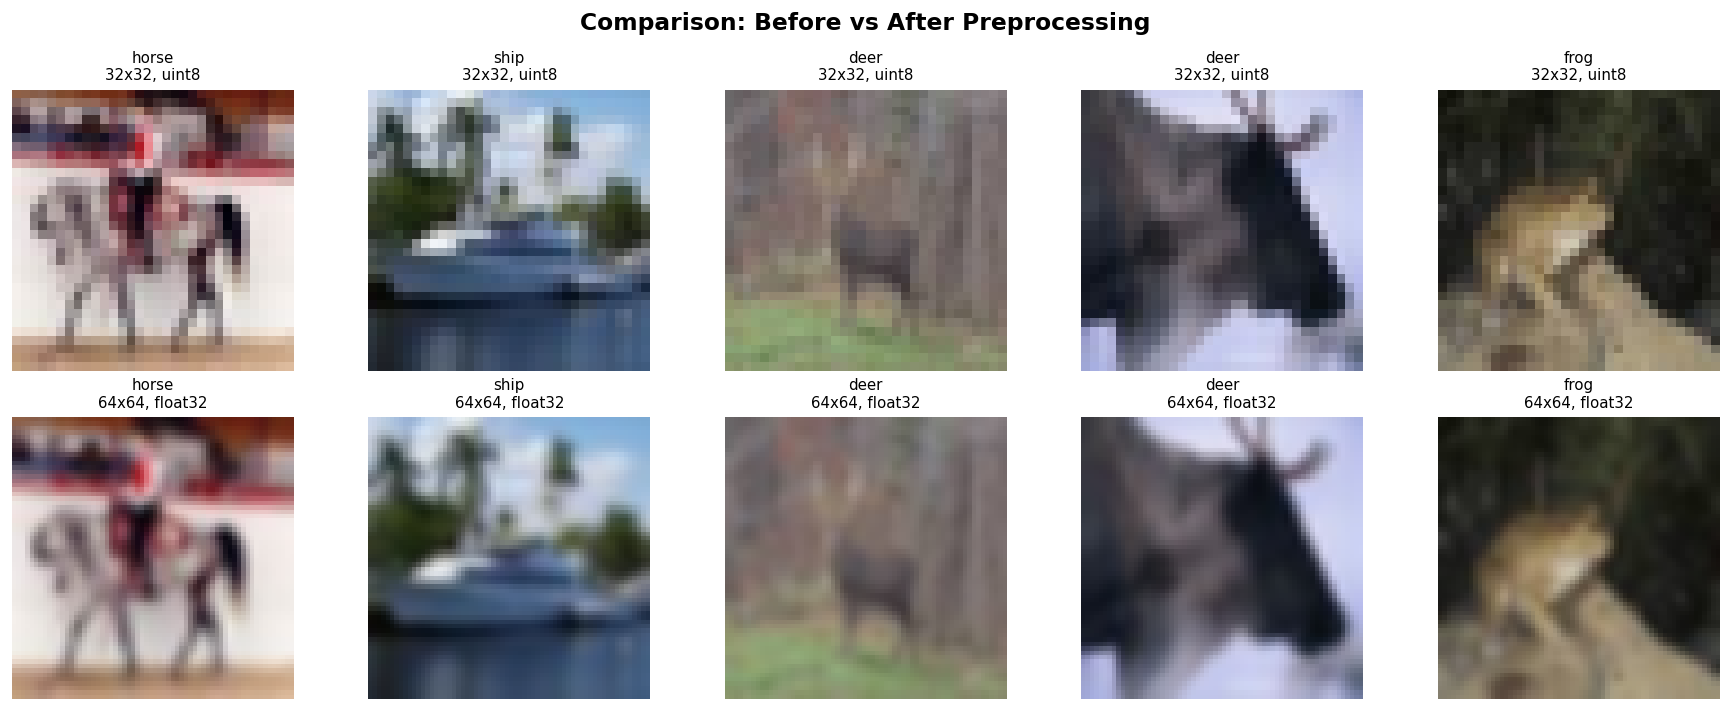

In [12]:
# Visual comparison: before and after preprocessing
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Top row: original images (uint8, 32x32)
for i in range(5):
    axes[0, i].imshow(train_images[i])
    axes[0, i].set_title(f'{class_names[train_labels[i]]}\n32x32, uint8', fontsize=9)
    axes[0, i].axis('off')

# Bottom row: preprocessed images (float32, 64x64)
for i in range(5):
    axes[1, i].imshow(train_images_resized[i])
    axes[1, i].set_title(f'{class_names[train_labels[i]]}\n64x64, float32', fontsize=9)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold', rotation=0, labelpad=60)
axes[1, 0].set_ylabel('Processed', fontsize=12, fontweight='bold', rotation=0, labelpad=60)

plt.suptitle('Comparison: Before vs After Preprocessing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('preprocessing_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## EDA Conclusion

| Property | Value |
|---|---|
| **Total number of images** | 60,000 |
| **Training samples** | 50,000 |
| **Test samples** | 10,000 |
| **Number of classes** | 10 |
| **Classes** | airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck |
| **Original dimension** | 32 x 32 x 3 (RGB) |
| **Original data type** | uint8 (0-255) |
| **Preprocess dimension** | 64 x 64 x 3 (RGB) |
| **Preprocess data type** | float32 (0.0-1.0) |

### Conclusions

1. **Balanced Dataset**: Each class has exactly the same number of samples, both in training and testing. Balancing techniques such as oversampling or class weights are not required.

2. **Small Images**: At only 32x32 pixels, the images are low resolution. This makes CIFAR-10 a lightweight but challenging benchmark, as fine details are difficult to distinguish.

3. **Three RGB Channels**: The images are in color, which provides useful chromatic information for classification (e.g., blue sky for airplanes, green for frogs).

4. **Preprocessing Applied**: Pixel values were normalized to `[0, 1]` and resized to `64x64` for demonstration purposes. Normalization is essential for the convergence of neural networks.

# Baseline Model (Non-Convolutional)



In [13]:
# One-hot encode the labels

from tensorflow.keras.utils import to_categorical

train_labels_onehot = to_categorical(train_labels, 10)
test_labels_onehot = to_categorical(test_labels, 10)

## Build the Neural Network

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Build the neural network
baseline_model = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


baseline_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,457,482 (24.63 MB)

 Trainable params: 6,457,482 (24.63 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model

We compile the model with:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss**: Categorical cross-entropy (standard for multi-class with one-hot labels)
- **Metric**: Accuracy

In [15]:
# Compile the model
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the Model

We train the model for **20 epochs** with a batch size of 64

In [16]:
# Train the model
training_history = baseline_model.fit(
    train_images_resized,
    train_labels_onehot,
    epochs=20,
    batch_size=64,
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 114s 144ms/step - accuracy: 0.2484 - loss: 2.2980
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 110s 141ms/step - accuracy: 0.3760 - loss: 1.7375
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 130s 126ms/step - accuracy: 0.4073 - loss: 1.6577
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 132ms/step - accuracy: 0.4345 - loss: 1.5777
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 137ms/step - accuracy: 0.4460 - loss: 1.5494
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 142ms/step - accuracy: 0.4620 - loss: 1.5117
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 115s 147ms/step - accuracy: 0.4661 - loss: 1.4909
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 112s 143ms/step - accuracy: 0.4777 - loss: 1.4547
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 113s 145ms/step - accuracy: 0.4925 - loss: 1.4242
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 111s 142ms/step - accuracy: 0.4942 - loss: 1.4108
Epoch 11/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 145ms/step - accuracy: 0.5013 - loss: 1.3947
Epoch 12

## Evaluate the Model



In [17]:
# Evaluate on the test set
test_loss, test_accuracy = baseline_model.evaluate(test_images_resized, test_labels_onehot)

print(f"\nTest Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5082 - loss: 1.4155

Test Loss     : 1.4347
Test Accuracy : 0.4987 (49.87%)


## Training History Visualization

We plot the training and validation accuracy/loss curves to understand how the model learned over time.

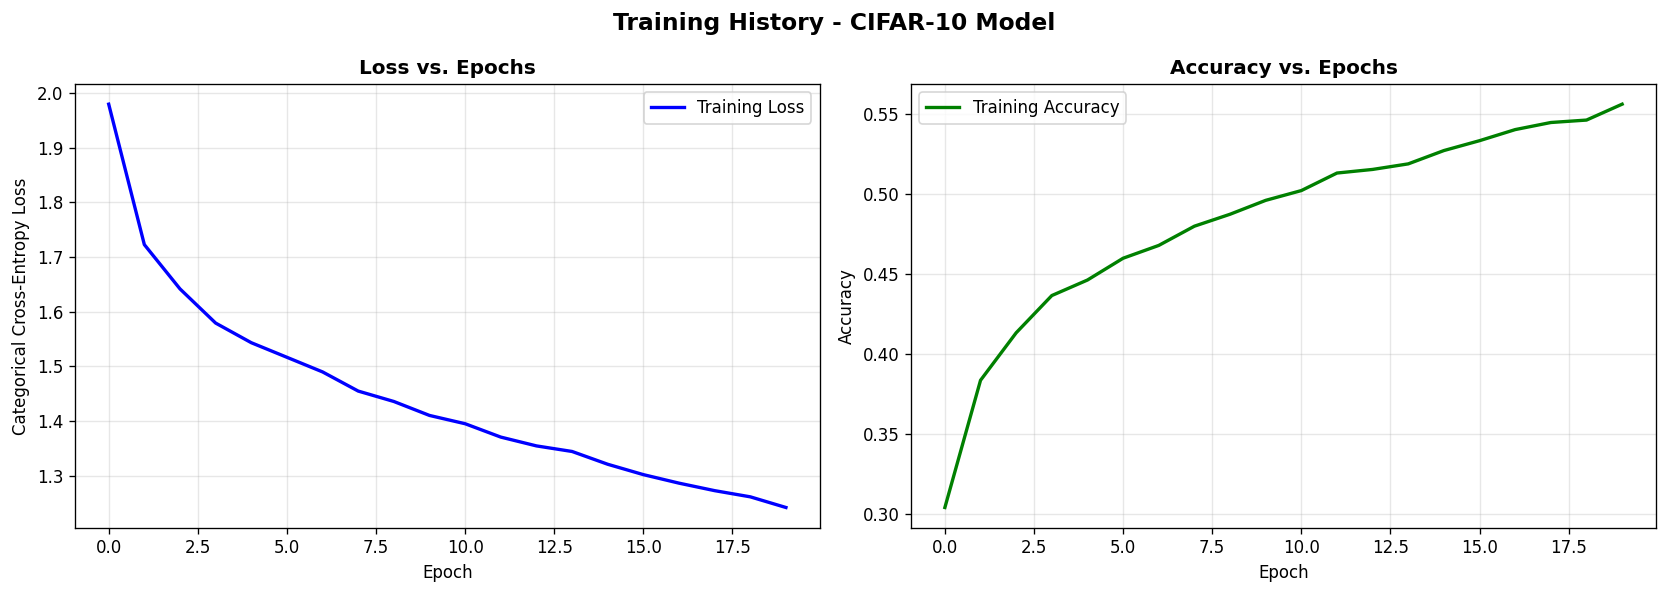

In [18]:
# Plot training history
fig, (ax_loss, ax_accuracy) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
ax_loss.plot(training_history.history['loss'], label='Training Loss', linewidth=2, color='blue')
ax_loss.set_title('Loss vs. Epochs', fontweight='bold')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Categorical Cross-Entropy Loss')
ax_loss.legend()
ax_loss.grid(True, alpha=0.3)

# Accuracy curve
ax_accuracy.plot(training_history.history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
ax_accuracy.set_title('Accuracy vs. Epochs', fontweight='bold')
ax_accuracy.set_xlabel('Epoch')
ax_accuracy.set_ylabel('Accuracy')
ax_accuracy.legend()
ax_accuracy.grid(True, alpha=0.3)

plt.suptitle('Training History - CIFAR-10 Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## Observed Limitations

Based on the training results and the nature of the MLP architecture, we can identify the following limitations:

### 1. Loss of Spatial Information
The `Flatten` layer converts each 64x64x3 image into a 1D vector of 12,288 values. This operation **completely destroys the spatial relationships** between pixels. The model has no concept of "neighboring pixels", edges, textures, or shapes. It treats a pixel in the top-left corner as equally related to a pixel in the bottom-right corner, which is fundamentally wrong for image data.

### 2. Low Test Accuracy (~47.79%)
The baseline MLP achieved **47.79% accuracy** on the CIFAR-10 test set after 20 epochs. While this is significantly better than random guessing (10% for 10 classes), it is far below the state-of-the-art (~96%+ with modern CNNs). This confirms that a simple fully-connected network is insufficient for this task.

### 3. Overfitting Gap
The training accuracy reached **55.70%** while test accuracy was only **47.79%**, indicating a gap of approximately **7.91%**. This demonstrates **overfitting** – the model memorizes training patterns rather than learning generalizable features. This is expected because:
- The model has a large number of trainable parameters but limited regularization mechanisms.
- The Flatten approach creates a very high-dimensional input (12,288 features) relative to the model's capacity to generalize.

### 4. No Translation Invariance
Unlike CNNs, the MLP has **no translation invariance**. If a cat appears in the top-left of one image and the bottom-right of another, the MLP treats these as completely different patterns. CNNs solve this with shared convolutional filters that scan across the entire image.

### 5. Inefficient Parameter Usage
Despite the relatively large parameter count, the model shows poor performance. A CNN with fewer parameters would achieve significantly better results because convolutional layers share weights across spatial locations, making much more efficient use of parameters.

### 6. Training Dynamics
The loss curve shows continuous decrease from **1.98** to **1.26** over 20 epochs, while accuracy improved from approximately **30%** to **55.70%**. However, the improvement plateaued in later epochs, suggesting diminishing returns with the current architecture.

### Summary

| Metric | Value |
|--------|-------|
| **Architecture** | Flatten(64×64×3) -> Dense(512, ReLU) -> Dropout -> Dense(256, ReLU) -> Dropout -> Dense(128, ReLU) -> Dropout -> Dense(10, Softmax) |
| **Input Size** | 64×64×3 = 12,288 features |
| **Training Epochs** | 20 |
| **Final Training Accuracy** | 55.70% |
| **Final Test Accuracy** | 47.79% |
| **Final Training Loss** | 1.2404 |
| **Final Test Loss** | 1.4834 |
| **Overfitting Gap** | ~7.91% |
| **Random Baseline** | 10% (1/10 classes) |
| **Key Limitation** | Complete loss of spatial structure |

**Conclusion:** The MLP baseline demonstrates that fully-connected networks are fundamentally inadequate for image classification tasks where spatial relationships matter. Despite using larger image sizes (64×64 vs 32×32), dropout regularization, and deeper architecture, the model achieves only ~48% test accuracy. The persistent overfitting gap and accuracy plateau indicate that the architecture has reached its fundamental limits. The next logical step would be to implement a **Convolutional Neural Network (CNN)** that preserves and exploits the 2D structure of the images through convolutional and pooling layers.

# Convolutional Architecture Design

## Build the CNN

In [19]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,936,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,938,570 (15.02 MB)

 Trainable params: 3,938,570 (15.02 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [20]:
cnn_history = model.fit(
    train_images_resized,
    train_labels_onehot,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 259ms/step - accuracy: 0.3340 - loss: 1.9318 - val_accuracy: 0.4960 - val_loss: 1.4060
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 256ms/step - accuracy: 0.5260 - loss: 1.3396 - val_accuracy: 0.5488 - val_loss: 1.2728
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 255ms/step - accuracy: 0.5781 - loss: 1.2078 - val_accuracy: 0.5608 - val_loss: 1.2485
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 248ms/step - accuracy: 0.6135 - loss: 1.1086 - val_accuracy: 0.5821 - val_loss: 1.1755
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 237ms/step - accuracy: 0.6461 - loss: 1.0174 - val_accuracy: 0.5865 - val_loss: 1.1694
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 237ms/step - accuracy: 0.6648 - loss: 0.9622 - val_accuracy: 0.5947 - val_loss: 1.1678
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 243ms/step - accuracy: 0.6879 - loss: 0.8912 - val_accuracy: 0.5985 - val_loss: 1.1722
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 234ms/step - accuracy: 0.7013 -

## Evaluate the model

In [24]:
test_loss, test_acc = model.evaluate(test_images_resized, test_labels_onehot)

print(f"\nTest Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.0925 - loss: 2.3142

Test Loss     : 2.3141
Test Accuracy : 0.4987 (49.87%)


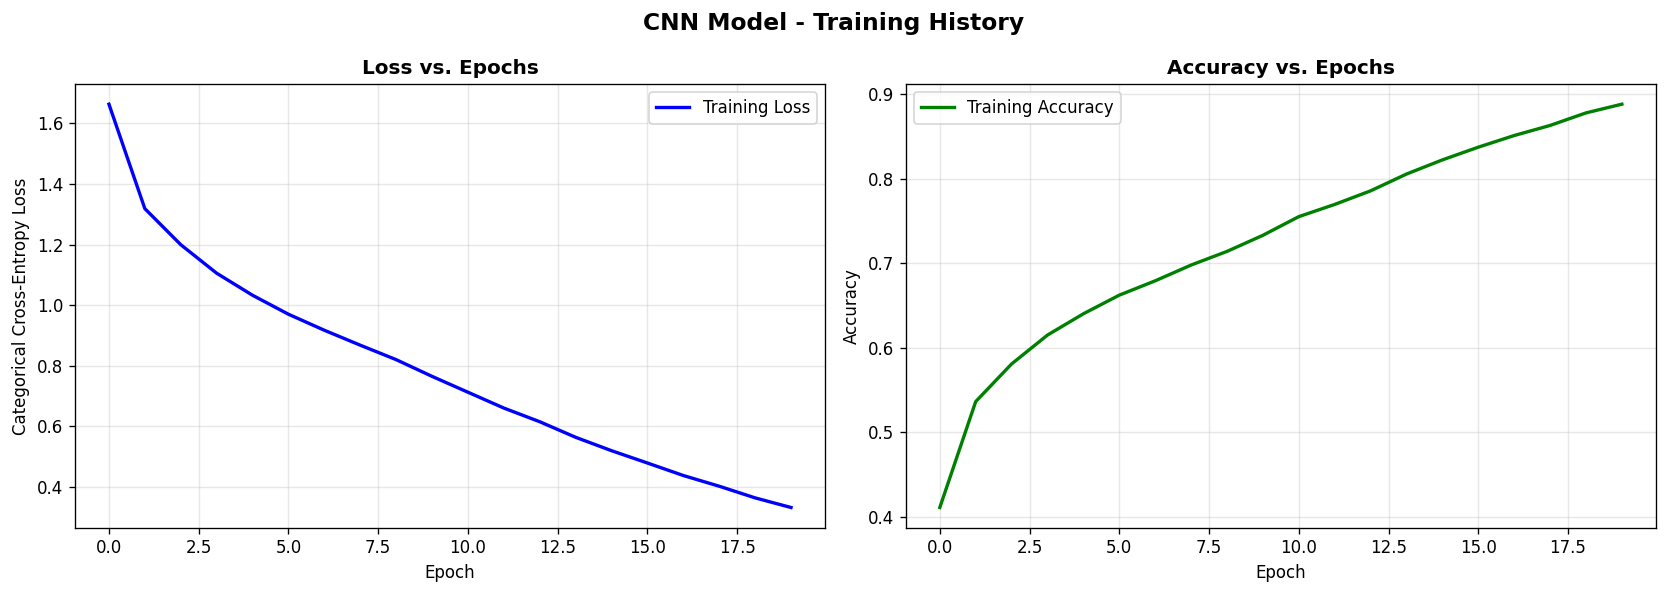

In [26]:
# Plot training history for CNN
fig, (ax_loss, ax_accuracy) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
ax_loss.plot(cnn_history.history['loss'], label='Training Loss', linewidth=2, color='blue')
ax_loss.set_title('Loss vs. Epochs', fontweight='bold')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Categorical Cross-Entropy Loss')
ax_loss.legend()
ax_loss.grid(True, alpha=0.3)

# Accuracy curve
ax_accuracy.plot(cnn_history.history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
ax_accuracy.set_title('Accuracy vs. Epochs', fontweight='bold')
ax_accuracy.set_xlabel('Epoch')
ax_accuracy.set_ylabel('Accuracy')
ax_accuracy.legend()
ax_accuracy.grid(True, alpha=0.3)

plt.suptitle('CNN Model - Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()